In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
## extract foreground and background masks
def getMask(img_dir, thresh,color):
    img_pil=Image.open(img_dir)
    img= np.array(img_pil, dtype='float')/255.0
    img = img[:,:,0:3]
    ny,nx,nc = img.shape
    temp = np.ones((ny,nx,nc))
    for i in range(nc):
        temp[:,:,i] *=color[i]
        
        
    return np.mean((img-temp)**2, axis=2)<=thresh

intensityThresh=1/255
fg_mask = getMask("../data/simple_scribbled_images/apples_foreground_connected.png", intensityThresh, np.array([1.0,1.0,1.0]))
bg_mask = getMask("../data/simple_scribbled_images/apples_background_connected.png", intensityThresh, np.array([1.0,1.0,1.0]))


In [3]:
img_dir="../data/simple_scribbled_images/apples.jpg"
img_pil=Image.open(img_dir)
img= np.array(img_pil, dtype='float')/255.0
img = img[:,:,0:3]
nx,ny,nc = img.shape

def extractInformationFromImage(img, mask):
    indices = np.nonzero(mask)
    N_fore = len(indices[1])
    pixel_info = np.zeros((5,N_fore)) # store x,y,R,G,B values of all pixels the user marked as foreground

    pixel_info[0,:] = indices[0] / nx - 0.5
    pixel_info[1,:] = indices[1] / ny - 0.5
    pixel_info[2:5,:] = img[indices[0], indices[1],:].T
    return pixel_info

fg_pix = torch.tensor(extractInformationFromImage(img, fg_mask).T).float()
bg_pix = torch.tensor(extractInformationFromImage(img, bg_mask).T).float()

all_pix = torch.concat((bg_pix,fg_pix), axis = 0)
labels = torch.zeros((all_pix.shape[0],1))
labels[0:bg_pix.shape[0]]=1

batch_size = int(all_pix.shape[0]/2)
train_dataset = torch.utils.data.TensorDataset(all_pix, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [8]:
all_pix.shape

torch.Size([3720, 5])

In [2]:
import torch

from awesome.util.reflection import class_name


class_name(torch.nn.BCELoss)

'torch.nn.modules.loss.BCELoss'

In [8]:
all_pix.shape

torch.Size([3720, 5])

In [22]:
class myConvexNet(nn.Module):
    def __init__(self,n_hidden):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.W0y = nn.Linear(2, n_hidden)
        self.W1z = nn.Linear(n_hidden, n_hidden)
        self.W2z = nn.Linear(n_hidden, 1)
        
        # something skippy
        self.W1y = nn.Linear(2, n_hidden,bias=False)
        self.W2y = nn.Linear(2, 1,bias=False)
        
    def forward(self, x):
        # define forward pass
        x_input = x
        x = F.relu(self.W0y(x))
        x = F.relu(self.W1z(x) + self.W1y(x_input))
        x = self.W2z(x) + self.W2y(x_input)
        return x
    
class myNet(nn.Module):
    def __init__(self,n_hidden):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.W0 = nn.Linear(5, n_hidden)
        self.W1 = nn.Linear(n_hidden, n_hidden)
        self.W2 = nn.Linear(n_hidden, 1)
        
        
    def forward(self, x):
        # define forward pass
        x_input = x
        x = F.relu(self.W0(x))
        x = F.relu(self.W1(x))
        x = self.W2(x)
        return x

In [27]:
net = myNet(130)
convexNet = myConvexNet(130)

# Loss and optimizer
criterion = nn.BCELoss()
#optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)  
optimizer = torch.optim.Adam(list(net.parameters())+list(convexNet.parameters()), lr=1e-2)  

num_epochs = 50

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (pixels, labels) in enumerate(train_loader):  
        random_pix = torch.tensor(extractInformationFromImage(img, np.random.rand(nx,ny)<0.0033).T).float()
        inputData = torch.concat((pixels, random_pix), axis=0)

        #inputData = pixels
        # Forward pass
        outputs = torch.sigmoid(net(inputData))
        loss = criterion(outputs[0:batch_size,:], labels)
        
        
        outputsConv = torch.sigmoid(convexNet(inputData[:,0:2]))

        #print(outputsConv.max())
        loss += criterion(outputsConv[0:batch_size,:], labels) 
        if epoch>30:
            loss += 10*torch.mean((outputsConv[batch_size:,:]-(outputs[batch_size:,:]>0.5).float())**2)
        
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            convexNet.W1z.weight.data = F.relu(convexNet.W1z.weight.data)
            convexNet.W2z.weight.data = F.relu(convexNet.W2z.weight.data)
        
    if (epoch+1) % 5 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [5/50], Step [2/2], Loss: 0.9304
Epoch [10/50], Step [2/2], Loss: 0.5136
Epoch [15/50], Step [2/2], Loss: 0.4173
Epoch [20/50], Step [2/2], Loss: 0.3654
Epoch [25/50], Step [2/2], Loss: 0.3237
Epoch [30/50], Step [2/2], Loss: 0.3036
Epoch [35/50], Step [2/2], Loss: 0.7801
Epoch [40/50], Step [2/2], Loss: 0.6348
Epoch [45/50], Step [2/2], Loss: 0.4945
Epoch [50/50], Step [2/2], Loss: 0.4361


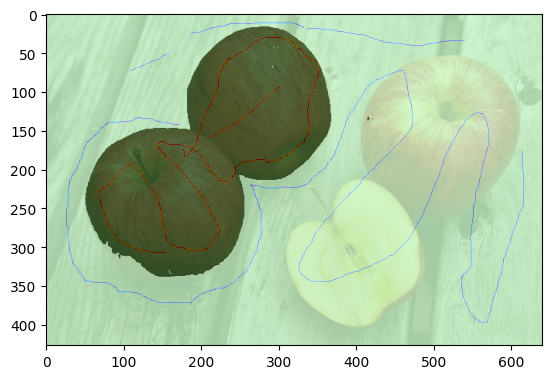

In [28]:
#print(net.W1z.weight.data,net.W2z.weight.data)

allPixels = torch.tensor(extractInformationFromImage(img, np.ones((nx,ny), dtype=bool)).T).float()

inferenceResult = net(allPixels[:,:]) # torch tensor of size nx*ny
inferenceResult = inferenceResult.detach().numpy().reshape((nx,ny))
plt.imshow(img)
plt.imshow(inferenceResult<=0, cmap='binary', alpha=0.7)
plt.imshow(fg_mask.astype(float)-bg_mask.astype(float), cmap='jet', alpha=0.3)
plt.show()


In [8]:
lrelu = lambda x: 0.3*torch.minimum(x,torch.tensor(0)) + torch.maximum(x,torch.tensor(0))
class myDiffeomorphism(nn.Module):
    def __init__(self,layers):
        # call constructor from superclass
        super().__init__()
        
        self.layers = layers
        self.stabi = 0.5
        
        # define matrices and biases
        temp = 0.01*torch.randn(2,2,layers)
        for i in range(layers):
            temp[:,:,i] += torch.eye(2)
            
        self.W = nn.Parameter(temp.clone(), requires_grad=True)
        
        
        self.b =  nn.Parameter(torch.zeros(2,layers), requires_grad=True)
        
        
    def forward(self, x):
        # define forward pass
        for i in range(self.layers-1):
            x = lrelu(self.stabi*x + x@(self.W[:,:,i]) + self.b[:,i])#@self.W[:,:,i].T
        
        x = self.stabi*x + x@(self.W[:,:,-1]) + self.b[:,-1]
        return x

In [9]:
#lrelu = lambda x: 2.3*torch.minimum(x,torch.tensor(0)) + torch.maximum(x,torch.tensor(0))
class myDiffeomorphism2(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        self.l1a_scale = nn.Linear(1,50)
        self.l1b_scale = nn.Linear(50,1)
        
        self.l1a_bias = nn.Linear(1,50)
        self.l1b_bias = nn.Linear(50,1)
        
        self.l2a_scale = nn.Linear(1,50)
        self.l2b_scale = nn.Linear(50,1)
        
        self.l2a_bias = nn.Linear(1,50)
        self.l2b_bias = nn.Linear(50,1)
        
        self.final = nn.Linear(2,2)
        
    def forward(self, x):
        # define forward pass
        s = self.l1b_scale(F.relu(self.l1a_scale(x[:,0].view(-1,1))))
        t = self.l1b_bias(F.relu(self.l1a_bias(x[:,0].view(-1,1))))
        
        
        xx = x[:,1]*torch.exp(s).view(-1) + t.view(-1)
        
        s = self.l2b_scale(F.relu(self.l2a_scale(xx.view(-1,1))))
        t = self.l2b_bias(F.relu(self.l2a_bias(xx.view(-1,1))))
        
        yy = x[:,0]*torch.exp(s).view(-1) + t.view(-1)
        
        return self.final(torch.concat((xx.view(-1,1),yy.view(-1,1)), axis=1)) 

In [30]:
net = myNet(130)
convexNet = myConvexNet(80)
diffeo = myDiffeomorphism2()
#diffeo = myDiffeomorphism(5)

# Loss and optimizer
criterion = nn.BCELoss()
#optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)  
optimizer = torch.optim.Adam(list(net.parameters())+list(convexNet.parameters())+list(diffeo.parameters()), lr=1e-2)  

num_epochs = 550

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (pixels, labels) in enumerate(train_loader):  
        random_pix = torch.tensor(extractInformationFromImage(img, np.random.rand(nx,ny)<0.005).T).float()
        
        inputData = torch.concat((pixels, random_pix), axis=0)

        # Forward pass
        outputs = torch.sigmoid(net(inputData))
        loss = criterion(outputs[0:batch_size,:], labels)
        
        
        outputsConv = torch.sigmoid(convexNet(diffeo(inputData[:,0:2])))

        #print(outputsConv.max())
        loss += criterion(outputsConv[0:batch_size,:], labels) 
        if epoch>30:
            if epoch<600:
                loss += torch.mean((outputsConv[batch_size:,:]-(outputs[batch_size:,:]>0.5).float())**2)
            else:
                loss += torch.mean((outputsConv[batch_size:,:]-(outputs[batch_size:,:]).float())**2)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            convexNet.W1z.weight.data = F.relu(convexNet.W1z.weight.data)
            convexNet.W2z.weight.data = F.relu(convexNet.W2z.weight.data)
        
    if (epoch+1) % 5 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        

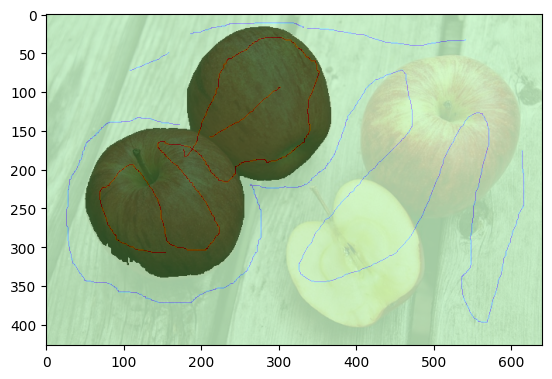

In [11]:
#print(net.W1z.weight.data,net.W2z.weight.data)

allPixels = torch.tensor(extractInformationFromImage(img, np.ones((nx,ny), dtype=bool)).T).float()

inferenceResult = convexNet(diffeo(allPixels[:,:2]))
inferenceResult = net((allPixels[:,:]))
inferenceResult = inferenceResult.detach().numpy().reshape((nx,ny))
plt.imshow(img)
plt.imshow(inferenceResult<=0, cmap='binary', alpha=0.7)
plt.imshow(fg_mask.astype(float)-bg_mask.astype(float), cmap='jet', alpha=0.3)
plt.show()


In [128]:
diffeo.W

Parameter containing:
tensor([[[ 0.9759,  0.9753,  0.9752,  0.9769,  0.9723],
         [ 0.0816,  0.0826,  0.0765,  0.0410, -0.1332]],

        [[ 0.1018,  0.1114,  0.1142,  0.0978,  0.0438],
         [ 0.9401,  0.9408,  0.9415,  0.9432,  0.9486]]], requires_grad=True)

In [ ]:
model = myNet(130)